In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords


from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression

In [25]:
dataset = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
dataset.shape

(7613, 5)

In [27]:
dataset.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [28]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [29]:
dataset['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [30]:
disaster_tweets = dataset[dataset.target == 1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [31]:
not_disaster_tweet = dataset[dataset.target == 0]['text']
not_disaster_tweet.values[1]

'I love fruits'

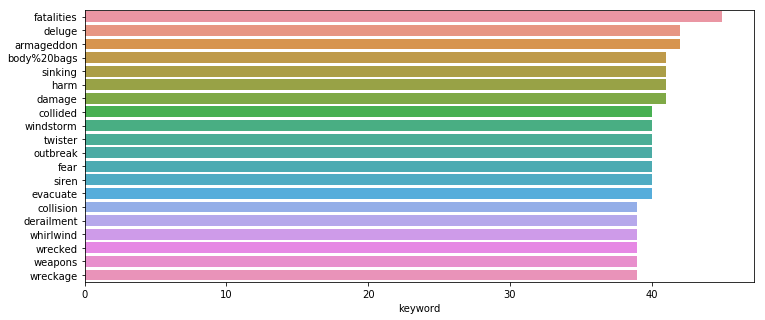

In [32]:
plt.figure(figsize = (12,5))
sns.barplot(y = dataset.keyword.value_counts()[:20].index, x = dataset.keyword.value_counts()[:20])

In [33]:
dataset['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [34]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

dataset['text'] = dataset['text'].apply(lambda x:clean_text(x))
test['text'] = dataset['text'].apply(lambda x:clean_text(x))

dataset['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Text(0.5,1,'Not Disaster Tweets')

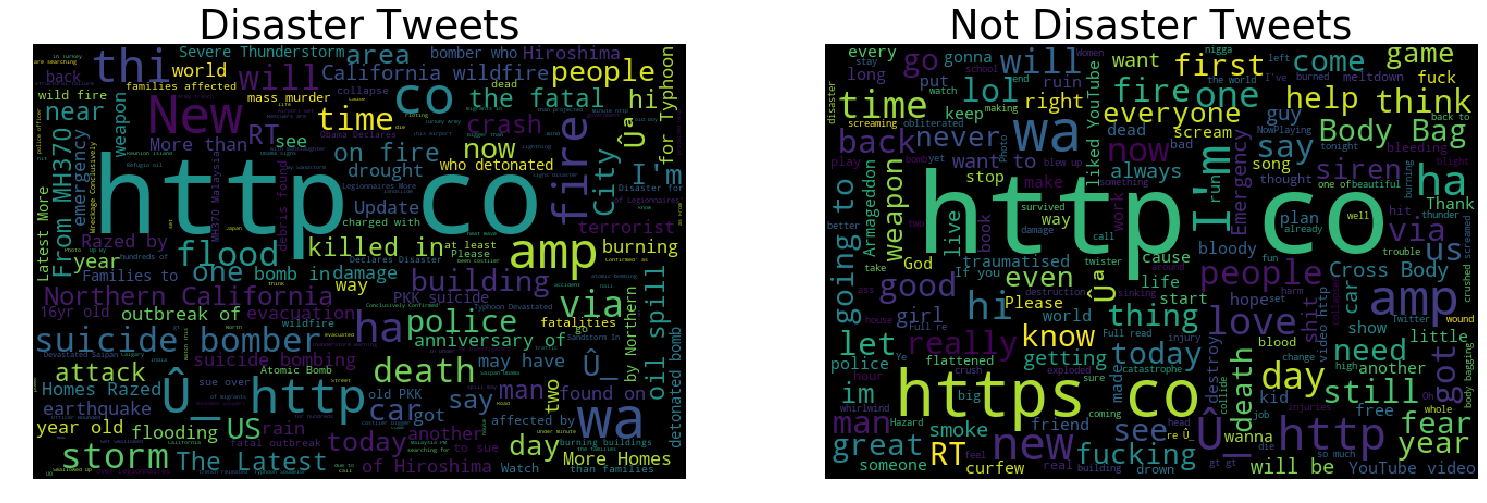

In [35]:
from wordcloud import WordCloud

fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize = [26,8])
wordcloud1 = WordCloud(background_color = 'black' , width = 600 , height = 400).generate(" ".join(disaster_tweets))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets' , fontsize = 40)

wordcloud2 = WordCloud(background_color = 'black' , height = 400 , width = 600).generate(" ".join(not_disaster_tweet))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not Disaster Tweets' , fontsize = 40)

#### Tokenization
Input sequence that splits an input sequence into so called tokens where the tokens can be word, tokens, sentences and paragraphs

In [36]:
text = "Are you coming, are'nt you?"

tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')
print(tokenizer1.tokenize(text) , tokenizer2.tokenize(text) , tokenizer3.tokenize(text) , tokenizer4.tokenize(text))

['Are', 'you', 'coming,', "are'nt", 'you?'] ['Are', 'you', 'coming', ',', "are'nt", 'you', '?'] ['Are', 'you', 'coming', ',', 'are', "'", 'nt', 'you', '?'] ['Are', 'you', 'coming', 'are', 'nt', 'you']


In [37]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(lambda x:tokenizer.tokenize(x))

test['text'] = test['text'].apply(lambda x:tokenizer.tokenize(x))

In [38]:
dataset.loc[0,['text']]

text    [our, deeds, are, the, reason, of, this, earth...
Name: 0, dtype: object

In [40]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [41]:
dataset['text'] = dataset['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x:remove_stopwords(x))

In [42]:
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [44]:
def combine_text(text):
    return ' '.join(text)

dataset['text'] = dataset['text'].apply(lambda x:combine_text(x))
test['text'] = dataset['text'].apply(lambda x:combine_text(x))

In [50]:
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [46]:
def text_preporcessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punc = clean_text(text)
    tokenized_text = tokenizer.tokenize(no_punc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = combine_text(remove_stopwords)
    
    return combined_text

In [53]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(dataset['text'])
test_vectors = count_vectorizer.transform(test['text'])

In [52]:
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1 , 2))
train_tfidf = tfidf_vectorizer.fit_transform(dataset['text'])
test_tfidf = tfidf_vectorizer.transform(test['text'])

In [55]:
clf = LogisticRegression(C = 1.0)
score = model_selection.cross_val_score(clf , train_vectors , dataset['target'] , cv = 5 , scoring = 'f1')
score

c:\users\kiit\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.59865255, 0.50301464, 0.57118787, 0.5669145 , 0.68888889])

In [56]:
clf.fit(train_vectors , dataset['target'])

c:\users\kiit\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
clf_tfidf = LogisticRegression(C = 1.0)
scores = model_selection.cross_val_score(clf_tfidf , train_tfidf , dataset['target'] , cv = 5 , scoring = 'f1')
scores

c:\users\kiit\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.57258065, 0.49626866, 0.54277829, 0.46618106, 0.64768683])

In [60]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB , train_vectors , dataset['target'] , cv = 5 , scoring = 'f1')
scores

array([0.63324979, 0.60688666, 0.68718683, 0.64341085, 0.72505092])

In [61]:
clf_NB.fit(train_vectors , dataset['target'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
clf_NB_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_tfidf , train_tfidf , dataset['target'] , cv = 5 , scoring = 'f1')
scores

array([0.57590597, 0.57067603, 0.61188811, 0.5962963 , 0.7393745 ])

In [64]:
clf_NB_tfidf.fit(train_tfidf , dataset['target'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(max_depth = 7 , n_estimators = 200 , colsample_bytree = 0.8 , subsample = 0.8 , nthread = 10 , learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb , train_vectors , dataset['target'] , cv = 5 , scoring = 'f1')
scores

array([0.46085998, 0.3847619 , 0.44095941, 0.39451477, 0.53154876])

In [67]:
clf_xgb_tfidf = xgb.XGBClassifier(max_depth = 7 , n_estimators = 200 , colsample_bytree = 0.8 , subsample = 0.8 , nthread = 10 , learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb_tfidf , train_tfidf , dataset['target'] , cv = 5 , scoring = 'f1')
scores

array([0.47597765, 0.35153923, 0.42557252, 0.40384615, 0.52509653])

In [68]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [71]:
submission_file_path = "sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_tfidf,test_vectors)